# Evaluate Saliency Maps for 3-Way Macrophage/Monocyte Classifier

This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients`, `Saliency`, `DeepLift` and `NoiseTunnel` to attribute the label of the image to the input pixels and visualize it.
  
  **Note:** Before running this tutorial, please install the torchvision, and matplotlib packages.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from utils import *

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models
#from torchvision.transforms import functional

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import random
from MacDataset import MacDataset
import macnet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import traceback
import uuid

In [2]:
PATHS = [r"..\data\processed\alveolar.pickle", 
         r"..\data\processed\marrow.pickle",
         r"..\data\processed\monocyte.pickle"]
BATCH_SIZE = 4
NUM_WORKERS = 2

In the cell below we load test and train datasets, define image transformers

In [3]:
transforms = transforms.Compose([
    standardize_input()
    ])

In [4]:
raw_images = []
raw_labels = []
for i, path in enumerate(PATHS):
    path_data = pickle.load(open(path, "rb"))
    path_data["labels"][:] = i
    raw_images.append(path_data["images"])
    raw_labels.append(path_data["labels"])

images = np.vstack(raw_images)[:,[0],:,:]
labels = np.hstack(raw_labels)

fold_idx = list(range(len(labels)))
random.shuffle(fold_idx)
fold_idx = np.array_split(fold_idx, 5)
min_len = len(labels)
for fold in fold_idx:
    if len(fold) < min_len:
        min_len = len(fold)

for i in range(len(fold_idx)):
    if len(fold_idx[i]) > min_len:
        fold_idx[i] = np.delete(fold_idx[i], 0)

i = 0

testing_images = images[fold_idx[i]]
testing_labels = labels[fold_idx[i]]
training_images = np.delete(images, fold_idx[i], axis=0)
training_labels = np.delete(labels, fold_idx[i], axis=0)

trainset = MacDataset(training_images, training_labels, 
                            transform=transforms)
testset = MacDataset(testing_images, testing_labels,
                            transform=transforms)

train_sampler = equal_classes_sampler(trainset.labels)
test_sampler = equal_classes_sampler(testset.labels)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=train_sampler,
                        shuffle=False, num_workers=0)

testloader = DataLoader(testset, batch_size=BATCH_SIZE, sampler=test_sampler,
                        shuffle=False, num_workers=0) 


In [5]:
print(trainloader)

for batch, data in enumerate(trainloader): 
    print(data[0].shape, data[1].shape)
    img, label = data
    if batch < 2:
        break

torch.Size([4, 1, 96, 96]) torch.Size([4])


In [6]:
print("Using existing trained model")
net = torch.load('./model_fold_0')
net.to("cpu")
net.eval()

Using existing trained model


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In the cell below we load some images from the test dataset and perform predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


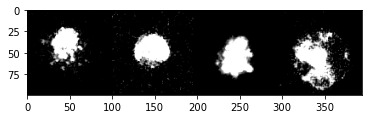

GroundTruth:    1.0   2.0   0.0   2.0
Predicted:    1.0   2.0   0.0   2.0


In [7]:

def imshow(img, transpose = True):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

outputs = net(images.float())
predicted = torch.argmax(outputs,1).to(torch.double)

print('Predicted: ', ' '.join('%5s' % predicted[j].item()
                              for j in range(4)))

Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

In [8]:
ind = 3

input = images[ind].unsqueeze(0).float()
input.requires_grad = True

A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

In [9]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=int(labels[ind].item()),
                                              **kwargs
                                             )
    
    return tensor_attributions
        

Computes gradients with respect to class `ind` and transposes them for visualization purposes.

In [10]:
saliency = Saliency(net)

print(type(input), input.shape, type(labels[ind].item()))
grads = saliency.attribute(input, target=int(labels[ind].item()))

grads = grads.squeeze().cpu().detach().numpy()

<class 'torch.Tensor'> torch.Size([1, 1, 96, 96]) <class 'float'>


Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index `ind` with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [11]:
ig = IntegratedGradients(net)
print(input.shape, (input.float() * 0).shape)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = attr_ig.squeeze(0).cpu().detach().numpy()
attr_ig = attr_ig.squeeze(0)
print('Approximation delta: ', abs(delta))

torch.Size([1, 1, 96, 96]) torch.Size([1, 1, 96, 96])
Approximation delta:  tensor([0.0350], dtype=torch.float64)


Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with `smoothgrad square` option adds gaussian noise with a standard deviation of `stdevs=0.2` to the input image `nt_samples` times, computes the attributions for `nt_samples` images and returns the mean of the squared attributions across `nt_samples` images.

In [12]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=10, stdevs=.5)
attr_ig_nt = attr_ig_nt.squeeze(0).cpu().detach().numpy()
attr_ig_nt = attr_ig_nt.squeeze(0)

Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

In [13]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = attr_dl.squeeze(0).cpu().detach().numpy()
attr_dl = attr_dl.squeeze(0)

In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift`, `Integrated Gradients` and `Integrated Gradients with SmoothGrad`.

Original Image
Predicted: tensor(2., dtype=torch.float64)  Probability: 0.9999673366546631


AttributeError: 'numpy.ndarray' object has no attribute 'colorbar'

<Figure size 1440x216 with 0 Axes>

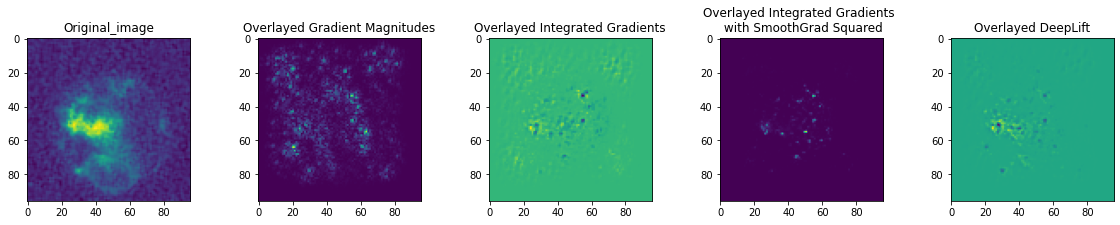

In [15]:
print('Original Image')
print('Predicted:', predicted[ind], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,5) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(original_image)
axarr[1].imshow(grads)
axarr[2].imshow(attr_ig)
axarr[3].imshow(attr_ig_nt)
axarr[4].imshow(attr_dl)

axarr[0].title.set_text("Original_image")
axarr[1].title.set_text("Overlayed Gradient Magnitudes")
axarr[2].title.set_text("Overlayed Integrated Gradients")
axarr[3].title.set_text("Overlayed Integrated Gradients \n with SmoothGrad Squared")
axarr[4].title.set_text("Overlayed DeepLift")
plt.colorbar()

suffix = str(uuid.uuid4())
predicted_class = str(int(predicted[ind].item()))
out_path = predicted_class + "_" + suffix
plt.savefig(out_path)